In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
%matplotlib inline
path = os.getcwd().split('/')

machine_path = '/' + path[1] + '/' + path[2]

plt.style.use(machine_path+'/opt/scripts/des.mplstyle')

In [7]:
##############################################################################
# Plot a data: domain, velocity field and rheology
##############################################################################

# total model horizontal extent (m)
Lx = 4000 * 1.0e3

# total model vertical extent (m)
Lz = 700 * 1.0e3

# number of points in horizontal direction
Nx = 401

# number of points in vertical direction
Nz = 71

# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3

# thickness of lower crust (m)
thickness_lower_crust = 20 * 1.0e3

# thickness of upper crust (m)
thickness_upper_crust = 20 * 1.0e3

# total thickness of lithosphere (m)
thickness_litho = 80 * 1.0e3#130 * 1.0e3

x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)
X, Z = np.meshgrid(x, z)
dz = Lz / (Nz - 1)

# Interfaces (bottom first)
interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

#Building mobile belt
interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
Lmb = 300.0e3 #length of mobile belt
N_Lmb = int(Lmb//dx)
# thinning = 50.0e3
thinning = 100.0e3

interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning

#Velocity field
fac_air = 10.0e3

#Left side
# 1 cm/year
vL = 0.005 / (365 * 24 * 3600)  # m/s

h_v_const = thickness_litho + 20.0e3  #thickness with constant velocity 
ha = Lz - thickness_sa - h_v_const  # difference

#Right side
vR = 2 * vL * (h_v_const + fac_air + ha) / ha  # this is to ensure integral equals zero

VX = np.zeros_like(X)
cond = (Z > h_v_const + thickness_sa) & (X == 0) #left side
VX[cond] = vR * (Z[cond] - h_v_const - thickness_sa) / ha

cond = (Z > h_v_const + thickness_sa) & (X == Lx) #right side
VX[cond] = vR * (Z[cond] - h_v_const - thickness_sa) / ha

# cond = X == Lx #right side
# VX[cond] += +2 * vL

cond = Z <= thickness_sa - fac_air
VX[cond] = 0

# print(np.sum(VX))

v0 = VX[(X == 0)]
vf = VX[(X == Lx)]
sv0 = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0
svf = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0
# print(sv0, svf, svf - sv0)

diff = (svf - sv0) * dz

vv = -diff / Lx
# print(vv, diff, svf, sv0, dz, Lx)

VZ = np.zeros_like(X)

cond = Z == 0
VZ[cond] = vv
#save bc to plot arraows in numerical setup
vels_bc = np.array([v0, vf])
vz0 = VZ[(z == 0)]

##############################################################################
# Plot b data: YSE
##############################################################################

L = Lz #130.0E3
N = 2*Nz-1 #261
z_yse = np.linspace(0,L,N)
dz_yse = z_yse[1]-z_yse[0]

rho = np.zeros_like(z_yse)
uc = z_yse<=20.0E3
lc = (z_yse>20.0E3)&(z_yse<=40.0E3)
lm = (z_yse>40.0E3)

rho[uc]=2700.0
rho[lc]=2800.0
rho[lm]=3354.0
g = 10.0

P = 0.0
Paux = 0.0
for i in range(1,N):
    Paux += dz_yse*rho[i]*g
    P = np.append(P,Paux)

phi = 2.0*np.pi/180.0
c0 = 4.0E6
sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

phi = 15.0*np.pi/180.0
c0 = 20.0E6
sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

#rheological params
Q = np.zeros_like(z_yse)
A = np.zeros_like(z_yse)
n = np.zeros_like(z_yse)
V = np.zeros_like(z_yse)
C = np.zeros_like(z_yse)

Q[uc]=222000.0
Q[lc]=222000.0
Q[lm]=540000.0

A[uc]=8.574E-28
A[lc]=8.574E-28
A[lm]=2.4168E-15

n[uc]=4.0
n[lc]=4.0
n[lm]=3.5

V[uc]=0.0
V[lc]=0.0
V[lm]=25.0E-6

T_yse = 1300 * z_yse / L

kappa = 1.0e-6

ccapacity = 1250

H = np.zeros_like(z_yse)
Huc = 2.5E-6/2700.0#old 9.2e-10
Hlc = 0.8E-6/2800.0#old 2.9e-10

H[uc] = Huc
H[lc] = Hlc

Taux = np.copy(T_yse)
t = 0
dt = 1000
dt_sec = dt * 365 * 24 * 3600

while t < 500.0e6:
    T_yse[1:-1] += kappa*dt_sec*((T_yse[2:]+T_yse[:-2]-2*T_yse[1:-1])/dz_yse**2) + H[1:-1]*dt_sec/ccapacity
    t = t + dt

#plt.plot(T,-z/1000)

#strain rate (sr)
sr = 1.0E-15

#gas constant
R = 8.314

#print(n)

#Temperature Kelvin
TK = T_yse + 273

# ##############################################################################
# # Plot d data: thermal profiles
# ##############################################################################

z = np.linspace(Lz, 0, Nz)
dz = Lz / (Nz - 1)

DTS = [0, 100, 200, 290, 350]
# DTS = [200, 290, 350]
Tzs = []

for DT in DTS:
    T = 1300 * (z - thickness_sa) / (thickness_litho) # Temperatura

    Ta = (1262 / np.exp(-10 * 3.28E-5 * (z - thickness_sa) / 1250)) + DT

    T[T < 0.0] = 0.0
    cond1 = Ta<T #VICTOR
    T[T > Ta] = Ta[T > Ta]

    kappa = 1.0e-6

    ccapacity = 1250

    H = np.zeros_like(T)

    cond = (z >= thickness_sa) & (z < thickness_upper_crust + thickness_sa) # upper crust
    H[cond] = Huc

    cond = (z >= thickness_upper_crust + thickness_sa) & (z < thickness_lower_crust + thickness_upper_crust + thickness_sa) # lower crust
    H[cond] = Hlc

    Taux = np.copy(T)
    t = 0
    dt = 5000
    dt_sec = dt * 365 * 24 * 3600
    #cond = (z>thickness_sa+thickness_litho) | (T == 0) #(T > 1300) | (T == 0) #OLD
    cond = cond1 | (T == 0)#VICTOR
    dz = Lz / (Nz - 1)

    while t < 500.0e6:
        T[1:-1] += kappa*dt_sec*((T[2:]+T[:-2]-2*T[1:-1])/dz**2) + H[1:-1]*dt_sec/ccapacity
        T[cond] = Taux[cond]
        t = t + dt

    Tz = np.copy(T)

    T = np.ones_like(X) * T[:, None]

    Tzs.append(Tz)

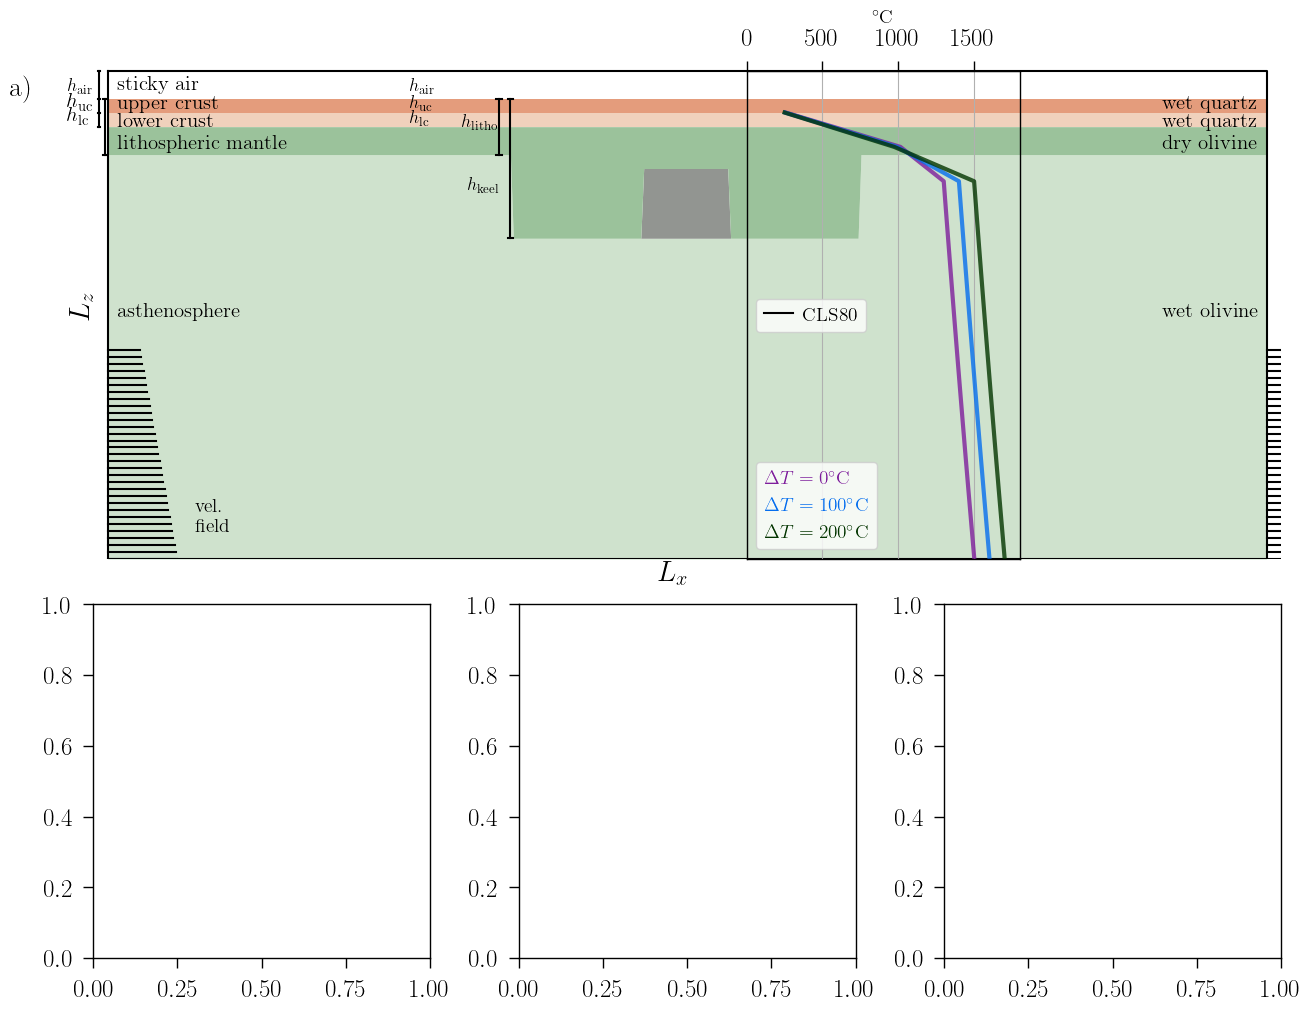

In [79]:
plt.close()
fig = plt.figure(figsize=(13,10), constrained_layout=True)
mosaic = """
         AAA
         BCD
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.7,0.5]})
fsize=16

##############################################################################
# Subplot a) Layers, seed, veloc field and precipitation profile
##############################################################################

# axs['A'].text(-120, 12, r"a)", size=20)
axs['A'].text(-0.07, 0.95, 'a)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['A'].transAxes)

axs['A'].set_xlim(0 - 50, Lx/1000 + 50)
axs['A'].set_ylim(-Lz/1000, 10)
# axs['A'].set_yticks([])
# axs['A'].set_xticks([])
axs['A'].axis('off')

#box domain contour
axs['A'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

#layers colour scheme
cr = 255.
color_uc = (228./cr,156./cr,124./cr)
color_lc = (240./cr,209./cr,188./cr)
color_lit = (155./cr,194./cr,155./cr)
color_ast = (207./cr,226./cr,205./cr)

# interfaces = {
#     "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
#     "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
#     "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
#     "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
#     "air": np.ones(Nx) * (thickness_sa),
#     }

#paint layers
a1 = interfaces["litho_LAB"]
a2 = a1*0+700.0E3
axs['A'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["litho_HETERO"]
axs['A'].fill_between(x/1000,-a1/1000,-a2/1000,fc='xkcd:gray',ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["lower_crust"]
axs['A'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["upper_crust"]
axs['A'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["air"]
axs['A'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)


scale_veloc = 20000*365.*24.*3600.
for i in range(0, np.size(z)-40, 1):
    if VX[i,0]!=0.0:
        axs['A'].plot([scale_veloc*VX[i, 0],0], [-z[i]/1000,-z[i]/1000], "k")

for i in range(0, np.size(z)-40, 1):
    axs['A'].plot([scale_veloc*VX[i, -1]+Lx/1000, Lx/1000], [-z[i]/1000,-z[i]/1000], "k")


axs['A'].text(300,-660,"vel.\nfield",fontsize=fsize-2)

#Naming layers
fsize=15
axs['A'].text(0.02, 0.96, "sticky air", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)
axs['A'].text(0.02, 0.92, "upper crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)
axs['A'].text(0.02, 0.885, "lower crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)
axs['A'].text(0.02, 0.84, "lithospheric mantle", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)
axs['A'].text(0.02, 0.50, "asthenosphere", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)

#Rheology
axs['A'].text(0.9, 0.92, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)
axs['A'].text(0.9, 0.885, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)
axs['A'].text(0.9, 0.84, 'dry olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)
axs['A'].text(0.9, 0.50, 'wet olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['A'].transAxes)

dx = 5
displx = -30

axs['A'].plot([-100, -100], [0, -Lz/1000], "k")
axs['A'].plot([-100-dx, -100+dx], [0,0], "k")
axs['A'].plot([-100-dx, -100+dx], [-Lz/1000, -Lz/1000], "k")

tickx = [displx-dx, displx+dx]
#layers bars - horizontal ticks
axs['A'].plot([displx,displx], [0,-80], "k") #air
axs['A'].plot(tickx, [0,0], "k")
axs['A'].plot(tickx, [-40,-40], "k")
axs['A'].plot(tickx, [-60,-60], "k")
axs['A'].plot(tickx, [-80,-80], "k")



# axs['A'].plot([1380,1400], [-80, -80], "k")
xpos = 1390

#thickness of cratonic region
axs['A'].plot([xpos-10, xpos+10], [-40, -40], "k") #upper horizontal bar
axs['A'].plot([xpos, xpos], [-40,-240], "k") #vertical bar
axs['A'].plot([xpos-10, xpos+10], [-240, -240], "k") #lower horizontal bar

#thickness of non-cratonic region
xpos2 = 1350    
axs['A'].plot([xpos2-10, xpos2+10], [-40, -40], "k") #upper horizontal bar
axs['A'].plot([xpos2, xpos2], [-40,-120], "k") #vertical bar
axs['A'].plot([xpos2-10, xpos2+10], [-120, -120], "k") #lower horizontal bar

axs['A'].text(xpos-170, -80, r"$h_{\mathrm{litho}}$", fontsize=fsize-2, rotation=0)
axs['A'].text(xpos-150, -170, r"$h_{\mathrm{keel}}$", fontsize=fsize-2, rotation=0)

# axs['A'].plot([xpos-10, xpos+10], [-80, -80], "k")




axs['A'].text(xpos-350, -30, r"$h_{\mathrm{air}}$", fontsize=fsize-2, rotation=0)
axs['A'].text(xpos-350, -54, r"$h_{\mathrm{uc}}$", fontsize=fsize-2)
axs['A'].text(xpos-350, -74, r"$h_{\mathrm{lc}}$", fontsize=fsize-2)





#hlines of layer thickness vlines
axs['A'].plot([-10,-10], [-40,-120],"k") #hlit
axs['A'].plot([-10-dx,-10+dx], [-40,-40],"k")#huc
axs['A'].plot([-10-dx,-10+dx], [-80-40,-80-40],"k") #hlc

#Layers thickness
axs['A'].text(-110+displx, -30, r"$h_{\mathrm{air}}$", fontsize=fsize-2, rotation=0)
axs['A'].text(-110+displx, -52, r"$h_{\mathrm{uc}}$", fontsize=fsize)
axs['A'].text(-110+displx, -72, r"$h_{\mathrm{lc}}$", fontsize=fsize)
# axs['A'].text(-46,-115,r"$h_{\mathrm{litho}}$", fontsize=fsize, rotation=90)

#Lz and Lx
# axs['A'].text(-135,-170,"700 km",rotation=90, fontsize=fsize+4)
# axs['A'].text(Lx/1000/2-100,-Lz/1000-15,"1600 km", fontsize=fsize+4)
axs['A'].text(-135, -350, r"$L_z$",rotation=90, fontsize=fsize+6)
axs['A'].text(Lx/1000/2-100, -Lz/1000-30, r"$L_x$", fontsize=fsize+6)

##############################################################################
# Inset - Thermal profiles
##############################################################################
label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

ax_aux = axs['A'].inset_axes([0.55,
                              0.0,
                              0.23,
                              0.985])

ax_aux.get_yaxis().set_visible(False)
ax_aux.set_xlabel('$^{\circ}$C', fontsize=label_size-4)
ax_aux.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax_aux.xaxis.set_label_position('top')
ax_aux.set_facecolor("none")
ax_aux.xaxis.grid('-k', alpha=1)

ax_aux.set_xlim([0,1800])
ax_aux.set_xticks([0, 500, 1000, 1500])
ax_aux.set_ylim(-Lz/1000, 10)

z = np.linspace(Lz, 0, Nz)
cT = z>=40000.0

colors = ['xkcd:purple', 'xkcd:cerulean blue', 'xkcd:dark green']#, 'xkcd:orange', 'xkcd:scarlet']
lines = ['-', '-', '-']#, '-', '-']

for Tz, color, line in zip(Tzs[0:3], colors, lines):
    ax_aux.plot(Tz[cT][::5], -(z[cT][::5]/1000), line, color=color, linewidth=3, alpha=0.8)

axt = ax_aux.twinx()
axt1 = ax_aux.twinx()
axt.axis('off')
axt1.axis('off')

axt.plot([-10, -10], [-10, -10], '-k', label='CLS80')
axt.legend(loc='center left', handlelength=1.5, handletextpad=0.5, fontsize=14)

axt1.plot([-10, -10], '-', color='xkcd:purple', label=r'$\Delta T = 0^{\circ}$C')
axt1.plot([-10, -10], '-', color='xkcd:cerulean blue', label=r'$\Delta T = 100^{\circ}$C')
axt1.plot([-10, -10], '-', color='xkcd:dark green', label=r'$\Delta T = 200^{\circ}$C')
axt1.legend(loc='lower left', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=14)


##############################################################################
# Subplot b) YSE's
##############################################################################

# axs['B'].text(-0.45, 1, 'b)', color='k', fontsize=20,
#         horizontalalignment='left', verticalalignment='center',
#         transform=axs['B'].transAxes)

# #Viscosity
# #Choosing C for layers
# C[uc]=1.0
# Cslc = [1, 10]
# C[lm]=1.0

# colors = ['black','black']
# lines = ['-.', '-']

# for clc, color, line in zip(Cslc, colors, lines):
#     C[lc] = clc
#     visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))

#     sigma_v = visc * sr

#     cond = sigma_v>sigma_max
#     sigma_v[cond]=sigma_max[cond]
#     axs['B'].plot(sigma_v/1.0E9, -z_yse/1000, linestyle=line, color=color, alpha=0.7)

#     if clc==Cslc[-1]:
#         cr = 255.
#         color_uc = (228./cr, 156./cr, 124./cr)
#         color_lc = (240./cr, 209./cr, 188./cr)
#         color_lit = (155./cr, 194./cr, 155./cr)
#         color_ast = (207./cr, 226./cr, 205./cr)

#         #filling inside YSE
#         axs['B'].fill_betweenx(-z_yse[uc]/1000,z_yse[uc]*0,sigma_v[uc]/1.0E9,color=color_uc,ec="k")
#         axs['B'].fill_betweenx(-z_yse[lc]/1000,z_yse[lc]*0,sigma_v[lc]/1.0E9,color=color_lc,ec="k")
#         axs['B'].fill_betweenx(-z_yse[lm]/1000,z_yse[lm]*0,sigma_v[lm]/1.0E9,color=color_lit,ec="k")

#         gray=0.
#         axs['B'].plot(sigma_min/1.0E9,-z_yse/1000,"--",color=(gray,gray,gray))
#         axs['B'].plot(sigma_max/1.0E9,-z_yse/1000,"--",color=(gray,gray,gray))
        
# label_size=22
# plt.rc('xtick', labelsize=label_size)
# plt.rc('ytick', labelsize=label_size)

# axs['B'].set_xlim(0, 0.5)
# axs['B'].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
# axs['B'].set_ylim(-130, 0)
# axs['B'].set_xlabel("GPa", fontsize=label_size)

# if i==1:
#     #bv1.set_yticklabels([])	
#     axs['B'].set_ylabel("km", fontsize=label_size)
# #     plt.title("coupled lithosphere")
# else:
# #     plt.title("strain rate: $10^{-15}$ s$^{-1}$")
#     axs['B'].set_ylabel("km", fontsize=label_size)

# axs['B'].grid('k')

# ##############################################################################
# # Subplot c) strain softening
# ##############################################################################

# axs['C'].text(-0.45, 1, 'c)', color='k', fontsize=20,
#         horizontalalignment='left', verticalalignment='center',
#         transform=axs['C'].transAxes)

# # xdata = np.array([0, 0.05, 1.05, 1.1])
# xdata = np.array([0, 0.25, 0.75, 1.0])
# ydata = np.array([15, 15, 2, 2])

# axs['C'].plot(xdata, ydata, 'k-')

# axs['C'].set_xlim([0.10, 0.9])
# axs['C'].set_ylim([0, 17])
# axs['C'].set_xticks([0.25, 0.5, 0.75])
# axs['C'].set_xticklabels([0.05, ' ', 1.05])
# axs['C'].tick_params('x', top=True, labeltop=False)
# axs['C'].set_xlabel(r"$\varepsilon$", fontsize=label_size)

# axs['C'].set_yticks([2, 15])
# axs['C'].set_yticklabels(['2°', '15°'])
# axs['C'].set_ylabel('$\Phi_{\mathrm{eff}}$', fontsize=label_size)

# axsCt = axs['C'].twinx()
# axsCt.set_ylim([0, 17])
# axsCt.set_yticks([2, 15])
# axsCt.set_yticklabels([4, 20])
# axsCt.set_ylabel('Cohesion (MPa)', fontsize=label_size-2, rotation=270)

# ##############################################################################
# # Subplot d) Thermal profiles
# ##############################################################################
# axs['D'].text(-0.45, 1, 'd)', color='k', fontsize=20,
#         horizontalalignment='left', verticalalignment='center',
#         transform=axs['D'].transAxes)

# z = np.linspace(Lz, 0, Nz)
# cT = z>=40000.0

# colors = ['xkcd:dark green', 'xkcd:orange', 'xkcd:scarlet']
# # labels = ['$\Delta T$ = 200', '$\Delta T$ = 290', '$\Delta T$ = 350']
# lines = [':', ':', ':']
# lines150 = ['-', '-', '-']

# for Tz, color, line in zip(Tzs[2::], colors, lines):
#     axs['D'].plot(Tz[cT][::5], -(z[cT][::5]/1000)+40, line, color=color, linewidth=2.5, alpha=0.7)

# for Tz, color, line in zip(Tzs150, colors, lines150):
#     axs['D'].plot(Tz[cT][::5], -(z[cT][::5]/1000)+40, line, color=color, linewidth=2.5, alpha=0.7)


# axs['D'].grid('-k', alpha=0.7)
# axs['D'].set_xlim(0, 1800)
# axs['D'].set_xticks([0, 500, 1000, 1500])
# axs['D'].set_ylim(-300+40, 0)
# axs['D'].set_xlabel('$^{\circ}$C', fontsize=label_size)
# axs['D'].set_ylabel('km', fontsize=label_size)

# axsDt = axs['D'].twinx()
# axsDt1 = axs['D'].twinx()
# axsDt.axis('off')
# axsDt1.axis('off')

# axsDt.plot([-10, -10], [-10, -10], ':k', label='CPE80')
# axsDt.plot([-10, -10], [-10, -10], '-k', label='CPE150')
# axsDt.legend(loc='center left', handlelength=1.5, handletextpad=0.5, fontsize=14)

# # axsDt1.plot([-10, -10], '-', color='xkcd:purple', label=r'$\Delta T = 0^{\circ}$C')
# # axsDt1.plot([-10, -10], '-', color='xkcd:cerulean blue', label=r'$\Delta T = 100^{\circ}$C')
# axsDt1.plot([-10, -10], '-', color='xkcd:dark green', label=r'$\Delta T = 200^{\circ}$C')
# axsDt1.plot([-10, -10], '-', color='xkcd:orange', label=r'$\Delta T = 290^{\circ}$C')
# axsDt1.plot([-10, -10], '-', color='xkcd:scarlet', label=r'$\Delta T = 350^{\circ}$C')
# axsDt1.legend(loc='lower left', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=14)

fig.savefig('out/' + "NumSetup_Keel.pdf", dpi=400, bbox_inches='tight')
fig.savefig('out/' + "NumSetup_Keel.png", dpi=400, bbox_inches='tight')